In [91]:
# uncomment the install if they're not already installed
# installing rpy2 and loading so that I can use R within a python kernel if I start code cells with %%R
# !pip install rpy2
%load_ext rpy2.ipython
# !pip install kagglehub # so that I can the database

Error importing in API mode: ImportError("dlopen(/Users/minaheelkhan/anaconda3/lib/python3.11/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): symbol not found in flat namespace '_R_BaseEnv'")
Trying to import in ABI mode.


In [2]:
%%html
# putting all the markdown text in times new roman font
<style>
div.text_cell_render{
    font-family: "Times New Roman", serif;
}
</style>


# EDA

&nbsp;    &nbsp;    &nbsp;   &nbsp;    &nbsp;    &nbsp;    &nbsp;    &nbsp;     testing indent textsfdfdsfdsnfdsf dsljfd;kl dhfdsd djkfdklfdklbf dkfjdslkht jakltj lkjahdf kjadsf dsljfd;kl dhfdsd djkfdklfdklbf dkfjdslkht jakltj lkjahdf kjadsf dsljfd;kl dhfdsd djkfdklfdklbf dkfjdslkht jakltj lkjahdf kjadsf dsljfd;kl dhfdsd djkfdklfdklbf dkfjdslkht jakltj lkjahdf kjadsf dsljfd;kl dhfdsd djkfdklfdklbf dkfjdslkht jakltj lkjahdf kjadsf dsljfd;kl dhfdsd djkfdklfdklbf dkfjdslkht jakltj lkjahdf kjadsf dsljfd;kl dhfdsd djkfdklfdklbf dkfjdslkht jakltj lkjahdf kjadsf dsljfd;kl dhfdsd djkfdklfdklbf dkfjdslkht jakltj lkjahdf kjads

## Variables we need (based on the paper)

We will keep variables needed for:

### A) Sample restriction
- Cycle indicator (to restrict to 2011–2012 and 2013–2014)
- Age (RIDAGEYR)
- Sex (RIAGENDR)

### B) Cognitive outcomes
Paper uses CERAD, Animal Fluency, DSST, and turns them into a binary "low cognitive performance"
using the 25th percentile cutoff within age bands: 60–<70, 70–<80, >=80.

So we need the raw cognitive test scores from NHANES.

### C) Exposure variables (dietary recall)
Paper focuses on coffee/caffeine intake using 24h recalls (two days; averaged if both exist).
So we need coffee and caffeine-related dietary variables and (if available) recall reliability flags.

### D) Covariates for Models 1–4
Model 1: unadjusted
Model 2: age + sex
Model 3: + BMI, race, marital, alcohol, smoking, diabetes, stroke
Model 4: + education, physical activity, milk intake, sleep, total sugar, sat fat

## Variable Selection and NHANES Code Mapping

The original paper does not report the official NHANES variable codes used for
exposures, outcomes, or covariates. As a result, exact replication is not possible
without reconstructing variable definitions from NHANES documentation and prior
literature. We therefore selected standard NHANES variables that are consistent
with the conceptual descriptions provided in the paper and that are commonly used
in epidemiological analyses of cognitive function in older adults.

Table X summarises the variables used in our analysis, along with their official
NHANES variable names and data sources.

| Concept | NHANES Variable | Dataset | Description |
|-------|----------------|---------|-------------|
| Caffeine intake (mg/day) | `DRXTCAFF` | Dietary | Daily caffeine intake from coffee |
| CERAD score | `CFDCRC` | Questionnaire | CERAD delayed recall score |
| DSST score | `CFDDS` | Questionnaire | Digit Symbol Substitution Test score |
| Animal Fluency score | `CFDAST` | Questionnaire | Animal Fluency Test score |
| Age (years) | `RIDAGEYR` | Demographics | Age at interview |
| Sex | `RIAGENDR` | Demographics | 1 = male, 2 = female |
| Race/ethnicity | `RIDRETH1` | Demographics | NHANES race/ethnicity categories |
| Marital status | `DMDMARTL` | Demographics | Marital status |
| Body Mass Index | `BMXBMI` | Demographics | Body mass index (kg/m²) |
| Smoking status | `SMQ020` | Questionnaire | Ever smoked at least 100 cigarettes |
| Alcohol consumption | `ALQ101` | Questionnaire | Had ≥12 alcoholic drinks in any one year |
| Diabetes | `DIQ010` | Questionnaire | Doctor-diagnosed diabetes |
| Stroke | `MCQ160F` | Questionnaire | Doctor-diagnosed stroke |

By explicitly documenting variable choices and their NHANES codes, we aim to
improve transparency and reproducibility, and to highlight the practical challenges
of replicating observational analyses when variable definitions are not fully
reported.


In [17]:
# getting the data
import kagglehub

path = kagglehub.dataset_download("nguyenvy/nhanes-19882018")
print("Path to dataset files:", path)

Path to dataset files: /Users/minaheelkhan/.cache/kagglehub/datasets/nguyenvy/nhanes-19882018/versions/10


### What this cell does

1. Loads the Kaggle-clean NHANES files you’re using (`demographics_clean`, `dietary_clean`,
   `questionnaire_clean`, and `weights_clean`).
2. Keeps *only* the official NHANES variables we agreed on for replication:
   - Exposure: caffeine from coffee (`DRXTCAFF`)
   - Outcomes: CERAD (`CFDCRC`), DSST (`CFDDS`), Animal Fluency (`CFDAST`)
   - Covariates: age (`RIDAGEYR`), sex (`RIAGENDR`), BMI (`BMXBMI`), race (`RIDRETH1`),
     marital status (`DMDMARTL`), smoking (`SMQ020`), alcohol (`ALQ101`), diabetes (`DIQ010`),
     stroke (`MCQ160F`)
3. Merges them all into one dataset using `SEQN`.
4. Renames columns into cleaner names for modelling later.

In [19]:
import pandas as pd

demo = pd.read_csv(path + "/demographics_clean.csv")
diet = pd.read_csv(path + "/dietary_clean.csv")
quest   = pd.read_csv(path + "/questionnaire_clean.csv") 
resp  = pd.read_csv(path + "/response_clean.csv")

/var/folders/nk/m67jcr3d74gdqb7sq9_szhmr0000gn/T/ipykernel_5461/15609595.py:6: DtypeWarning: Columns (827,831,836,837,841,846,951,952,984,985,986,999,1000,1001) have mixed types. Specify dtype option on import or set low_memory=False.
  resp  = pd.read_csv(path + "/response_clean.csv")


In [40]:
# collapsing every tbale to one row per person

# Collapse dietary caffeine to one row per person
demo_1 = (
    demo[["SEQN", "RIDAGEYR", "RIAGENDR", "RIDRETH1", "DMDMARTL", "SDDSRVYR"]]
    .sort_values("SEQN")
    .groupby("SEQN", as_index=False)
    .agg(lambda s: s.dropna().iloc[0] if s.notna().any() else pd.NA)
)

diet_1 = (
    diet[["SEQN", "DRXTCAFF"]]
    .groupby("SEQN", as_index=False)
    .mean()
)

quest_1 = (
    quest[["SEQN", "ALQ101", "DIQ010", "MCQ160F"]]
    .sort_values("SEQN")
    .groupby("SEQN", as_index=False)
    .agg(lambda s: s.dropna().iloc[0] if s.notna().any() else pd.NA)
)

# Collapse BMI to one row per person
resp_1 = (
    resp[["SEQN", "BMXBMI"]]
    .groupby("SEQN", as_index=False)
    .mean()
)

In [68]:
import os
import urllib.request

# Create a folder to store NHANES XPT files
os.makedirs("nhanes_xpt", exist_ok=True)

# URLs for Cognitive Functioning files
cfq_g_url = "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2011/DataFiles/CFQ_G.xpt"
cfq_h_url = "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/CFQ_H.xpt"

# Local file paths
cfq_g_path = "nhanes_xpt/CFQ_G.xpt"
cfq_h_path = "nhanes_xpt/CFQ_H.xpt"

# Download files 
urllib.request.urlretrieve(cfq_g_url, cfq_g_path)
urllib.request.urlretrieve(cfq_h_url, cfq_h_path)

# Read XPT files
cfq_2011 = pd.read_sas(cfq_g_path, format="xport")
cfq_2013 = pd.read_sas(cfq_h_path, format="xport")

# Combine cycles
cfq = pd.concat([cfq_2011, cfq_2013], ignore_index=True)

# Keep only cognitive outcome variables
cfq = cfq[["SEQN", "CFDAST", "CFDDS", "CFDCSR"]]


# for smoking
smq_g_url = "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2011/DataFiles/SMQ_G.xpt"
smq_h_url = "https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/SMQ_H.xpt"

smq_g_path = "nhanes_xpt/SMQ_G.xpt"
smq_h_path = "nhanes_xpt/SMQ_H.xpt"

urllib.request.urlretrieve(smq_g_url, smq_g_path)
urllib.request.urlretrieve(smq_g_url, smq_g_path)

smq_2011 = pd.read_sas(smq_g_path, format="xport")
smq_2013 = pd.read_sas(smq_h_path, format="xport")

smq = pd.concat([smq_2011, smq_2013], ignore_index=True)
smq = smq[["SEQN", "SMQ020"]]

# Treat refused / don't know as missing
smq.loc[smq["SMQ020"].isin([7, 9]), "SMQ020"] = pd.NA

# Quick checks
print("CFQ shape:", cfq.shape)
print("SMQ shape:", smq.shape)

print(cfq.head())
print(smq.head())

CFQ shape: (3472, 4)
SMQ shape: (13958, 2)
      SEQN  CFDAST  CFDDS  CFDCSR
0  62174.0    18.0   33.0     5.0
1  62178.0    12.0   38.0     3.0
2  62191.0    17.0   26.0     5.0
3  62209.0    15.0    NaN     3.0
4  62215.0    15.0   47.0     7.0
      SEQN  SMQ020
0  62161.0     2.0
1  62163.0     NaN
2  62164.0     2.0
3  62165.0     NaN
4  62169.0     2.0


In [70]:
df = (
    demo_1[["SEQN", "RIDAGEYR", "RIAGENDR", "RIDRETH1", "DMDMARTL", "SDDSRVYR"]]
    .merge(diet_1[["SEQN", "DRXTCAFF"]], on="SEQN", how="left")
    .merge(quest_1[["SEQN", "ALQ101", "DIQ010", "MCQ160F"]], on="SEQN", how="left")
    .merge(resp_1[["SEQN", "BMXBMI"]], on="SEQN", how="left")
    .merge(cfq, on="SEQN", how="left")
    .merge(smq, on="SEQN", how = "left")
)

print("Merged df shape:", df.shape)
df[["SEQN","DRXTCAFF","CFDCSR","CFDDS","CFDAST","RIDAGEYR","RIAGENDR","RIDRETH1","DMDMARTL","BMXBMI","ALQ101","DIQ010","MCQ160F","SMQ020"]].head()


Merged df shape: (101316, 15)


,SEQN,DRXTCAFF,CFDCSR,CFDDS,CFDAST,RIDAGEYR,RIAGENDR,RIDRETH1,DMDMARTL,BMXBMI,ALQ101,DIQ010,MCQ160F,SMQ020
0,1,2.403969,NaN,NaN,NaN,2,2,4,<NA>,14.900,<NA>,2.0,<NA>,NaN
1,2,438.873869,NaN,NaN,NaN,77,1,3,<NA>,24.900,1.0,2.0,2.0,NaN
2,3,64.767744,NaN,NaN,NaN,10,2,3,5.0,21.565,<NA>,2.0,2.0,NaN
3,4,147.898003,NaN,NaN,NaN,1,1,4,1.0,23.400,<NA>,2.0,2.0,NaN
4,5,25.187899,NaN,NaN,NaN,49,1,3,1.0,29.100,1.0,2.0,2.0,NaN


In [71]:

df.head(50)

,SEQN,RIDAGEYR,RIAGENDR,RIDRETH1,DMDMARTL,SDDSRVYR,DRXTCAFF,ALQ101,DIQ010,MCQ160F,BMXBMI,CFDAST,CFDDS,CFDCSR,SMQ020
0,1,2,2,4,<NA>,1,2.403969,<NA>,2.0,<NA>,14.900,NaN,NaN,NaN,NaN
1,2,77,1,3,<NA>,1,438.873869,1.0,2.0,2.0,24.900,NaN,NaN,NaN,NaN
2,3,10,2,3,5.0,1,64.767744,<NA>,2.0,2.0,21.565,NaN,NaN,NaN,NaN
3,4,1,1,4,1.0,1,147.898003,<NA>,2.0,2.0,23.400,NaN,NaN,NaN,NaN
4,5,49,1,3,1.0,1,25.187899,1.0,2.0,2.0,29.100,NaN,NaN,NaN,NaN
5,6,19,2,5,5.0,1,242.637370,<NA>,2.0,<NA>,22.560,NaN,NaN,NaN,NaN
6,7,59,2,4,1.0,1,138.095114,2.0,2.0,2.0,21.595,NaN,NaN,NaN,NaN
7,8,13,1,3,<NA>,1,57.899996,<NA>,2.0,<NA>,15.510,NaN,NaN,NaN,NaN
8,9,11,2,4,1.0,1,244.184944,<NA>,2.0,2.0,22.990,NaN,NaN,NaN,NaN
9,10,43,1,4,4.0,1,88.184901,1.0,2.0,2.0,30.170,NaN,NaN,NaN,NaN


# Clean this code up

In [72]:
# One row per person
assert df["SEQN"].is_unique

# Missingness overview
(df.isna().mean() * 100).sort_values(ascending=False)

CFDDS       97.025149
CFDAST      96.930396
CFDCSR      96.914604
SMQ020      88.487504
ALQ101      56.947570
MCQ160F     36.118678
DMDMARTL    26.712464
DRXTCAFF     9.884915
BMXBMI       9.337123
DIQ010       3.539421
SEQN         0.000000
RIDAGEYR     0.000000
RIAGENDR     0.000000
RIDRETH1     0.000000
SDDSRVYR     0.000000
dtype: float64

In [73]:
df0 = df[df["SDDSRVYR"].isin([8, 9])].copy()

print("NHANES 2011–2014 participants:", df0["SEQN"].nunique())

#add number of participants excluded?

NHANES 2011–2014 participants: 20146


In [74]:
cog_vars = ["CFDCSR", "CFDDS", "CFDAST"]

df1 = df0[
    (df0["RIDAGEYR"] >= 60) &
    (df0[cog_vars].notna().any(axis=1))
].copy()

print("After cognitive-function screening (age>=60 + cognitive present):", df1["SEQN"].nunique())


After cognitive-function screening (age>=60 + cognitive present): 1680


In [75]:
(df1.isna().mean() * 100).sort_values(ascending=False)

DRXTCAFF    9.821429
CFDDS       5.238095
ALQ101      3.095238
BMXBMI      1.726190
CFDAST      1.130952
CFDCSR      0.476190
SMQ020      0.119048
SEQN        0.000000
RIDAGEYR    0.000000
RIAGENDR    0.000000
RIDRETH1    0.000000
DMDMARTL    0.000000
SDDSRVYR    0.000000
DIQ010      0.000000
MCQ160F     0.000000
dtype: float64

In [77]:
df_final = df1.dropna(subset=["DRXTCAFF"]).copy()

print("Final analytic sample size:", df_final["SEQN"].nunique())


Final analytic sample size: 1515


In [80]:
for v in ["SMQ020", "ALQ101", "DIQ010", "MCQ160F"]:
    df1.loc[df1[v].isin([7, 9]), v] = pd.NA


In [81]:
covars = ["SMQ020", "ALQ101", "DIQ010", "MCQ160F"]

df2 = df1.dropna(subset=covars).copy()

n2 = df2["SEQN"].nunique()


In [82]:
df3 = df2.dropna(subset=["DRXTCAFF"]).copy()

n3 = df3["SEQN"].nunique()


In [83]:
figure1 = pd.DataFrame({
    "Stage": [
        "NHANES 2011–2014 participants",
        "Aged ≥60 years with cognitive function measures",
        "Excluded missing covariates (smoking, alcohol, diabetes, stroke)",
        "Excluded incomplete or unreliable dietary recall",
        "Final analytic sample"
    ],
    "N": [
        n0,
        n1,
        n2,
        n3,
        n3
    ]
})

figure1


,Stage,N
0,NHANES 2011–2014 participants,20146
1,Aged ≥60 years with cognitive function measures,1680
2,"Excluded missing covariates (smoking, alcohol,...",1617
3,Excluded incomplete or unreliable dietary recall,1491
4,Final analytic sample,1491


# Onto Models

Next step: Define cognitive impairment (25th percentile)
What the paper does (conceptually)

After defining the final analytic sample, the paper:

Treats each cognitive test separately

Uses the 25th percentile of the test score as a cutoff

Defines cognitive impairment as a score below the 25th percentile

Runs models separately for each test

Estimaed causal effect of +50 mg of caffiene on each outcome var

In [86]:
# compute 25th percentile cutoffs
# 25th percentile cutoffs (computed separately)
cerad_cut = df_final["CFDCSR"].dropna().quantile(0.25)
dsst_cut  = df_final["CFDDS"].dropna().quantile(0.25)
af_cut    = df_final["CFDAST"].dropna().quantile(0.25)

cerad_cut, dsst_cut, af_cut


(5.0, 34.0, 13.0)

In [87]:
# making it a binary outcome
df_final["cerad_impair"] = ((df_final["CFDCSR"] < cerad_cut).astype("float"))

df_final["dsst_impair"] = ((df_final["CFDDS"] < dsst_cut).astype("float"))

df_final["af_impair"] = ((df_final["CFDAST"] < af_cut).astype("float"))


Cognitive outcomes and impairment definition

Cognitive performance was assessed using three tests: the CERAD delayed recall test, the Digit Symbol Substitution Test (DSST), and the Animal Fluency test. Each outcome was analysed separately. For each test, cognitive impairment was defined as a score below the 25th percentile of the distribution within the analytic sample, consistent with the original study. Participants were included in a given analysis if data for that specific cognitive test were available.

We would compare cutoffs, but the paper doesn't report the actual numeric 25th percentile value. 

In [94]:
# Make a copy so you don't mutate your original
df_final_r = df_final.copy()

# Columns that should be numeric in R
to_numeric = ["RIDAGEYR", "RIAGENDR", "RIDRETH1", "DMDMARTL",
              "DRXTCAFF", "BMXBMI", "ALQ101", "DIQ010", "MCQ160F",
              "CFDCSR", "CFDDS", "CFDAST"]


df_final_r.dtypes


SEQN              int64
RIDAGEYR          int64
RIAGENDR          int64
RIDRETH1          int64
DMDMARTL         object
SDDSRVYR          int64
DRXTCAFF        float64
ALQ101           object
DIQ010           object
MCQ160F          object
BMXBMI          float64
CFDAST          float64
CFDDS           float64
CFDCSR          float64
SMQ020          float64
cerad_impair    float64
dsst_impair     float64
af_impair       float64
dtype: object

In [95]:
%%R -i df_final_r
df <- df_final_r


## Model 1
Model 1 (Unadjusted).
We first estimated the unadjusted association between caffeine intake and cognitive impairment using logistic regression. Cognitive impairment was defined as performance below the 25th percentile for each cognitive test. Separate models were fitted for the CERAD delayed recall test, the Digit Symbol Substitution Test (DSST), and the Animal Fluency test.

Following the paper, Model 1 is unadjusted: we regress cognitive performance on caffeine intake only. We show one causal DAG for intuition (Age and Sex are plausible confounders), but we do not adjust for them in Model 1, to match the paper.
We then illustrate a simple model-based “+50 mg/day caffeine” contrast by predicting outcomes at two caffeine levels and taking the difference. This should be interpreted as an unadjusted association, not a definitive causal effect.

Plot coordinates for graph not supplied! Generating coordinates, see ?coordinates for how to set your own.


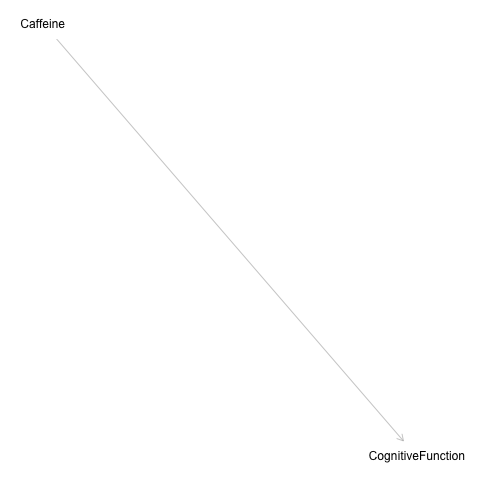

In [98]:
%%R

library(dagitty)

dag_m1 <- dagitty("dag {
  Caffeine -> CognitiveFunction
}")

plot(dag_m1)

In [103]:
%%R
# Model 1a: CERAD delayed recall
m1a_data <- subset(df, !is.na(CFDCSR) & !is.na(DRXTCAFF))
model_1a <- lm(CFDCSR ~ DRXTCAFF, data = m1a_data)

# +50 mg/day contrast (unadjusted association)
mean_caff <- mean(m1a_data$DRXTCAFF)

pred_plus50 <- predict(model_1a, newdata = data.frame(DRXTCAFF = mean_caff + 50))
pred_base   <- predict(model_1a, newdata = data.frame(DRXTCAFF = mean_caff))

effect_plus50_1a <- pred_plus50 - pred_base
effect_plus50_1a


         1 
0.08678178 


In [104]:
%%R
# Model 1b: DSST
m1b_data <- subset(df, !is.na(CFDDS) & !is.na(DRXTCAFF))
model_1b <- lm(CFDDS ~ DRXTCAFF, data = m1b_data)

mean_caff <- mean(m1b_data$DRXTCAFF)

pred_plus50 <- predict(model_1b, newdata = data.frame(DRXTCAFF = mean_caff + 50))
pred_base   <- predict(model_1b, newdata = data.frame(DRXTCAFF = mean_caff))

effect_plus50_1b <- pred_plus50 - pred_base
effect_plus50_1b


        1 
0.8253683 


In [105]:
%%R
# Model 1c: Animal Fluency
m1c_data <- subset(df, !is.na(CFDAST) & !is.na(DRXTCAFF))
model_1c <- lm(CFDAST ~ DRXTCAFF, data = m1c_data)

mean_caff <- mean(m1c_data$DRXTCAFF)

pred_plus50 <- predict(model_1c, newdata = data.frame(DRXTCAFF = mean_caff + 50))
pred_base   <- predict(model_1c, newdata = data.frame(DRXTCAFF = mean_caff))

effect_plus50_1c <- pred_plus50 - pred_base
effect_plus50_1c


        1 
0.3131869 


Markdown: Model 1 results (unadjusted)
Model 1: Unadjusted association between caffeine intake and cognitive performance

Model 1 examines the unadjusted association between caffeine intake and cognitive performance. Separate linear regression models were estimated for each cognitive test, with caffeine intake (mg/day) as the sole predictor. For interpretability, we report a model-based contrast corresponding to an increase of 50 mg/day of caffeine, computed using predicted values from the fitted model.

Model 1a: CERAD delayed recall

In the unadjusted model for CERAD delayed recall, a 50 mg/day increase in caffeine intake was associated with an estimated increase of 0.087 points in the CERAD delayed recall score. This association is small in magnitude and reflects an unadjusted relationship.

Model 1b: Digit Symbol Substitution Test (DSST)

In the unadjusted model for DSST performance, a 50 mg/day increase in caffeine intake was associated with an estimated increase of 0.83 points in the DSST score. Among the three cognitive tests considered, this outcome showed the largest unadjusted association with caffeine intake.

Model 1c: Animal Fluency

In the unadjusted model for Animal Fluency, a 50 mg/day increase in caffeine intake was associated with an estimated increase of 0.31 points in the Animal Fluency score. This effect size is modest and smaller than that observed for DSST.

Interpretation note (important — matches feedback)

These estimates represent unadjusted associations derived from linear regression models and should not be interpreted as causal effects. Age, sex, and other health and lifestyle factors are potential confounders of the relationship between caffeine intake and cognitive performance and are addressed in subsequent adjusted models.

(Optional one-line summary sentence)

Overall, Model 1 suggests weak to modest positive unadjusted associations between caffeine intake and cognitive test scores, with the strongest association observed for DSST performance.

We chose caffiene 50 mg, as a cup typically contain 95 grams of caffiene, so this represents half a cup more daily. (should we change it to 1 cup?)

## Model 2
Model 2: Age- and sex-adjusted association between caffeine intake and cognitive performance

Model 2 adjusts the association between caffeine intake and cognitive performance for age and sex, as shown in Figure 2. These variables are treated as confounders because they may influence both caffeine consumption patterns and cognitive performance.

Separate linear regression models were estimated for each cognitive outcome. As in Model 1, we report a model-based contrast corresponding to a 50 mg/day increase in caffeine intake. These estimates represent adjusted associations under the assumed linear model and should not be interpreted as causal effects.

Plot coordinates for graph not supplied! Generating coordinates, see ?coordinates for how to set your own.


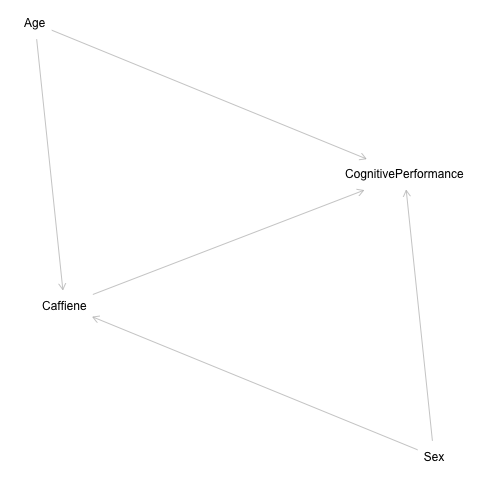

In [106]:
%%R
library(dagitty)

dag_m2 <- dagitty("dag {

  Age -> Caffiene
  Sex -> Caffiene

  Age -> CognitivePerformance
  Sex -> CognitivePerformance

  Caffiene -> CognitivePerformance
}
")

plot(dag_m2)


In [107]:
%%R
m2a_data <- subset(
  df,
  !is.na(CFDCSR) & !is.na(DRXTCAFF) &
  !is.na(RIDAGEYR) & !is.na(RIAGENDR)
)

model_2a <- lm(
  CFDCSR ~ DRXTCAFF + RIDAGEYR + RIAGENDR,
  data = m2a_data
)

summary(model_2a)

# +50 mg/day contrast
mean_caff <- mean(m2a_data$DRXTCAFF)
mean_age  <- mean(m2a_data$RIDAGEYR)
mean_sex  <- mean(m2a_data$RIAGENDR)

pred_plus50 <- predict(
  model_2a,
  newdata = data.frame(
    DRXTCAFF = mean_caff + 50,
    RIDAGEYR = mean_age,
    RIAGENDR = mean_sex
  )
)

pred_base <- predict(
  model_2a,
  newdata = data.frame(
    DRXTCAFF = mean_caff,
    RIDAGEYR = mean_age,
    RIAGENDR = mean_sex
  )
)

effect_plus50_2a <- pred_plus50 - pred_base
effect_plus50_2a


         1 
0.08331255 


In [108]:
%%R
m2b_data <- subset(
  df,
  !is.na(CFDDS) & !is.na(DRXTCAFF) &
  !is.na(RIDAGEYR) & !is.na(RIAGENDR)
)

model_2b <- lm(
  CFDDS ~ DRXTCAFF + RIDAGEYR + RIAGENDR,
  data = m2b_data
)

summary(model_2b)

mean_caff <- mean(m2b_data$DRXTCAFF)
mean_age  <- mean(m2b_data$RIDAGEYR)
mean_sex  <- mean(m2b_data$RIAGENDR)

pred_plus50 <- predict(
  model_2b,
  newdata = data.frame(
    DRXTCAFF = mean_caff + 50,
    RIDAGEYR = mean_age,
    RIAGENDR = mean_sex
  )
)

pred_base <- predict(
  model_2b,
  newdata = data.frame(
    DRXTCAFF = mean_caff,
    RIDAGEYR = mean_age,
    RIAGENDR = mean_sex
  )
)

effect_plus50_2b <- pred_plus50 - pred_base
effect_plus50_2b


        1 
0.7701548 


In [109]:
%%R
m2c_data <- subset(
  df,
  !is.na(CFDAST) & !is.na(DRXTCAFF) &
  !is.na(RIDAGEYR) & !is.na(RIAGENDR)
)

model_2c <- lm(
  CFDAST ~ DRXTCAFF + RIDAGEYR + RIAGENDR,
  data = m2c_data
)

summary(model_2c)

mean_caff <- mean(m2c_data$DRXTCAFF)
mean_age  <- mean(m2c_data$RIDAGEYR)
mean_sex  <- mean(m2c_data$RIAGENDR)

pred_plus50 <- predict(
  model_2c,
  newdata = data.frame(
    DRXTCAFF = mean_caff + 50,
    RIDAGEYR = mean_age,
    RIAGENDR = mean_sex
  )
)

pred_base <- predict(
  model_2c,
  newdata = data.frame(
    DRXTCAFF = mean_caff,
    RIDAGEYR = mean_age,
    RIAGENDR = mean_sex
  )
)

effect_plus50_2c <- pred_plus50 - pred_base
effect_plus50_2c


        1 
0.2797873 


Model 2 results (age- and sex-adjusted)
Model 2: Association between caffeine intake and cognitive performance adjusted for age and sex

Model 2 adjusts the association between caffeine intake and cognitive performance for age and sex, which may influence both caffeine consumption patterns and cognitive outcomes. Separate linear regression models were estimated for each cognitive test. As in Model 1, we report a model-based contrast corresponding to a 50 mg/day increase in caffeine intake.

Model 2a: CERAD delayed recall

After adjustment for age and sex, a 50 mg/day increase in caffeine intake was associated with an estimated increase of 0.083 points in the CERAD delayed recall score. This estimate is slightly smaller than the unadjusted estimate, indicating modest attenuation after demographic adjustment.

Model 2b: Digit Symbol Substitution Test (DSST)

In the age- and sex-adjusted model for DSST, a 50 mg/day increase in caffeine intake was associated with an estimated increase of 0.77 points in DSST performance. Although attenuated relative to Model 1, this remained the largest association among the three cognitive outcomes.

Model 2c: Animal Fluency

For Animal Fluency, a 50 mg/day increase in caffeine intake was associated with an estimated increase of 0.28 points after adjustment for age and sex. This represents a modest reduction compared with the unadjusted association.

## Model 3
Model 3: Fully adjusted association between caffeine intake and cognitive performance

Model 3 further adjusts the association between caffeine intake and cognitive performance for a set of health and lifestyle covariates in addition to age and sex. Specifically, we adjust for body mass index (BMI), race/ethnicity, marital status, smoking status, alcohol intake, diabetes, and history of stroke, as shown in Figure 3.

These variables may be associated with both caffeine consumption patterns and cognitive performance and are therefore included to reduce residual confounding. As in previous models, separate linear regressions are estimated for each cognitive outcome, and results are summarised using a 50 mg/day increase in caffeine intake.

Plot coordinates for graph not supplied! Generating coordinates, see ?coordinates for how to set your own.


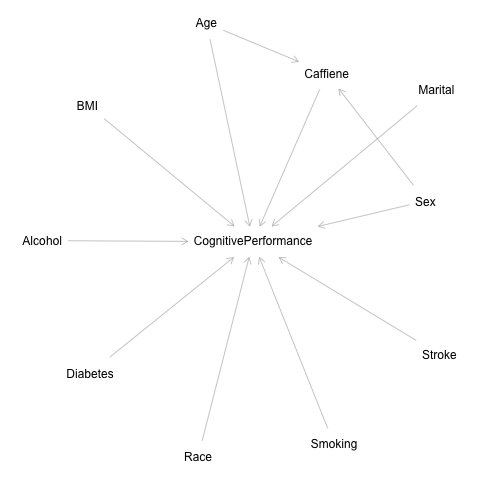

In [110]:
%%R
library(dagitty)

dag_m3 <- dagitty("dag {

  Age -> Caffiene
  Sex -> Caffiene

  Age -> CognitivePerformance
  Sex -> CognitivePerformance

  Caffiene -> CognitivePerformance

  BMI -> CognitivePerformance
  Race -> CognitivePerformance
  Marital -> CognitivePerformance
  Smoking -> CognitivePerformance
  Alcohol -> CognitivePerformance
  Stroke -> CognitivePerformance
  Diabetes -> CognitivePerformance
}
")

plot(dag_m3)


In [111]:
%%R
m3a_data <- subset(
  df,
  !is.na(CFDCSR) & !is.na(DRXTCAFF) &
  !is.na(RIDAGEYR) & !is.na(RIAGENDR) &
  !is.na(BMXBMI) & !is.na(RIDRETH1) &
  !is.na(DMDMARTL) & !is.na(SMQ020) &
  !is.na(ALQ101) & !is.na(DIQ010) &
  !is.na(MCQ160F)
)

model_3a <- lm(
  CFDCSR ~ DRXTCAFF + RIDAGEYR + RIAGENDR + BMXBMI +
    RIDRETH1 + DMDMARTL + SMQ020 + ALQ101 + DIQ010 + MCQ160F,
  data = m3a_data
)

summary(model_3a)

mean_caff <- mean(m3a_data$DRXTCAFF)

pred_plus50 <- predict(
  model_3a,
  newdata = transform(
    m3a_data[1, ],
    DRXTCAFF = mean_caff + 50
  )
)

pred_base <- predict(
  model_3a,
  newdata = transform(
    m3a_data[1, ],
    DRXTCAFF = mean_caff
  )
)

effect_plus50_3a <- pred_plus50 - pred_base
effect_plus50_3a


     71916 
0.07039414 


In [112]:
%%R
m3b_data <- subset(
  df,
  !is.na(CFDDS) & !is.na(DRXTCAFF) &
  !is.na(RIDAGEYR) & !is.na(RIAGENDR) &
  !is.na(BMXBMI) & !is.na(RIDRETH1) &
  !is.na(DMDMARTL) & !is.na(SMQ020) &
  !is.na(ALQ101) & !is.na(DIQ010) &
  !is.na(MCQ160F)
)

model_3b <- lm(
  CFDDS ~ DRXTCAFF + RIDAGEYR + RIAGENDR + BMXBMI +
    RIDRETH1 + DMDMARTL + SMQ020 + ALQ101 + DIQ010 + MCQ160F,
  data = m3b_data
)

summary(model_3b)

mean_caff <- mean(m3b_data$DRXTCAFF)

pred_plus50 <- predict(
  model_3b,
  newdata = transform(
    m3b_data[1, ],
    DRXTCAFF = mean_caff + 50
  )
)

pred_base <- predict(
  model_3b,
  newdata = transform(
    m3b_data[1, ],
    DRXTCAFF = mean_caff
  )
)

effect_plus50_3b <- pred_plus50 - pred_base
effect_plus50_3b


    71916 
0.6557154 


In [113]:
%%R
m3c_data <- subset(
  df,
  !is.na(CFDAST) & !is.na(DRXTCAFF) &
  !is.na(RIDAGEYR) & !is.na(RIAGENDR) &
  !is.na(BMXBMI) & !is.na(RIDRETH1) &
  !is.na(DMDMARTL) & !is.na(SMQ020) &
  !is.na(ALQ101) & !is.na(DIQ010) &
  !is.na(MCQ160F)
)

model_3c <- lm(
  CFDAST ~ DRXTCAFF + RIDAGEYR + RIAGENDR + BMXBMI +
    RIDRETH1 + DMDMARTL + SMQ020 + ALQ101 + DIQ010 + MCQ160F,
  data = m3c_data
)

summary(model_3c)

mean_caff <- mean(m3c_data$DRXTCAFF)

pred_plus50 <- predict(
  model_3c,
  newdata = transform(
    m3c_data[1, ],
    DRXTCAFF = mean_caff + 50
  )
)

pred_base <- predict(
  model_3c,
  newdata = transform(
    m3c_data[1, ],
    DRXTCAFF = mean_caff
  )
)

effect_plus50_3c <- pred_plus50 - pred_base
effect_plus50_3c


    71916 
0.2209798 


Model 3 results (fully adjusted)
Model 3: Fully adjusted association between caffeine intake and cognitive performance

Model 3 presents fully adjusted linear regression models examining the association between caffeine intake and cognitive performance. In addition to age and sex, models adjust for body mass index (BMI), race/ethnicity, marital status, smoking status, alcohol intake, diabetes, and history of stroke, as specified in the causal diagram for Model 3.

Separate models were estimated for each cognitive outcome. Results are summarised using a model-based contrast corresponding to a 50 mg/day increase in caffeine intake.

Model 3a: CERAD delayed recall

After full adjustment for demographic, lifestyle, and health-related covariates, a 50 mg/day increase in caffeine intake was associated with an estimated increase of 0.07 points in the CERAD delayed recall score. This estimate is smaller than those observed in Models 1 and 2, indicating substantial attenuation after accounting for additional confounders.

Model 3b: Digit Symbol Substitution Test (DSST)

In the fully adjusted model for DSST performance, a 50 mg/day increase in caffeine intake was associated with an estimated increase of 0.66 points in DSST score. Although attenuated relative to earlier models, this remained the largest association among the three cognitive outcomes.

Model 3c: Animal Fluency

For Animal Fluency, a 50 mg/day increase in caffeine intake was associated with an estimated increase of 0.22 points after full adjustment. This represents a further reduction compared with the unadjusted and age- and sex-adjusted models.

Overall interpretation of Model 3

Across all three cognitive outcomes, full adjustment led to further attenuation of the estimated associations between caffeine intake and cognitive performance. This pattern suggests that the positive associations observed in unadjusted models are largely explained by demographic, lifestyle, and health-related factors. The fully adjusted results provide limited evidence of an independent association between caffeine intake and cognitive performance in this cross-sectional NHANES sample.

# Model 4
BMI and smoking are treated as potential mediators, not pure confounders

Race remains a confounder

Age and sex remain baseline confounder

Model 4: Conditioning on potential mediators

Model 4 extends previous models by conditioning on variables that may lie on the causal pathway between caffeine intake and cognitive performance, specifically BMI and smoking status, while continuing to adjust for age, sex, and race/ethnicity.

In this model, BMI and smoking are not treated as confounders but as potential mediators. Conditioning on these variables allows exploration of whether the association between caffeine intake and cognitive performance persists after accounting for these pathways. As a result, estimates from Model 4 should not be interpreted as total effects and may reflect a direct association under strong assumptions.

# Not accurate, can't include dashed lines in dag model, we can replace all with our own diagram 

Plot coordinates for graph not supplied! Generating coordinates, see ?coordinates for how to set your own.


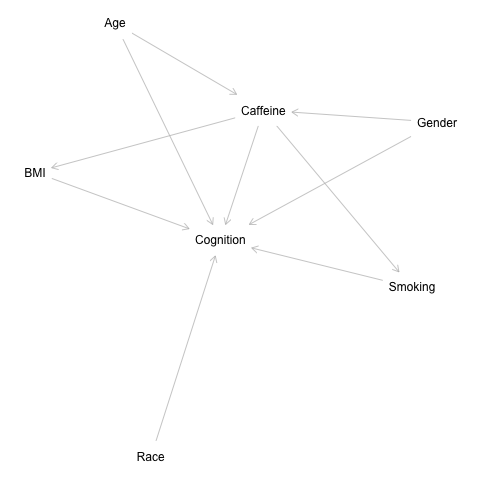

In [115]:
%%R
library(dagitty)

dag_model4 <- dagitty("dag {

  Gender -> Caffeine
  Age -> Caffeine

  Gender -> Cognition
  Age -> Cognition

  Caffeine -> Cognition

  Smoking -> Cognition
  BMI -> Cognition
  Race -> Cognition

  Caffeine -> Smoking
  Caffeine -> BMI
}
")

plot(dag_model4)


In [117]:
%%R
m4b_data <- subset(
  df,
  !is.na(CFDDS) & !is.na(DRXTCAFF) &
  !is.na(RIDAGEYR) & !is.na(RIAGENDR) &
  !is.na(RIDRETH1) & !is.na(BMXBMI) &
  !is.na(SMQ020)
)

model_4b <- lm(
  CFDDS ~ DRXTCAFF + RIDAGEYR + RIAGENDR + RIDRETH1 + BMXBMI + SMQ020,
  data = m4b_data
)

summary(model_4b)



Call:
lm(formula = CFDDS ~ DRXTCAFF + RIDAGEYR + RIAGENDR + RIDRETH1 + 
    BMXBMI + SMQ020, data = m4b_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-56.929 -11.020   0.367  11.375  52.524 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 77.495805   5.509090  14.067  < 2e-16 ***
DRXTCAFF     0.018051   0.003283   5.499 4.53e-08 ***
RIDAGEYR    -0.677827   0.063310 -10.706  < 2e-16 ***
RIAGENDR     4.875430   0.855090   5.702 1.44e-08 ***
RIDRETH1     2.209492   0.408811   5.405 7.59e-08 ***
BMXBMI      -0.135618   0.067147  -2.020   0.0436 *  
SMQ020       2.520578   0.864426   2.916   0.0036 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.8 on 1434 degrees of freedom
Multiple R-squared:  0.1304,	Adjusted R-squared:  0.1268 
F-statistic: 35.84 on 6 and 1434 DF,  p-value: < 2.2e-16



In [118]:
%%R
m4c_data <- subset(
  df,
  !is.na(CFDAST) & !is.na(DRXTCAFF) &
  !is.na(RIDAGEYR) & !is.na(RIAGENDR) &
  !is.na(RIDRETH1) & !is.na(BMXBMI) &
  !is.na(SMQ020)
)

model_4c <- lm(
  CFDAST ~ DRXTCAFF + RIDAGEYR + RIAGENDR + RIDRETH1 + BMXBMI + SMQ020,
  data = m4c_data
)

summary(model_4c)



Call:
lm(formula = CFDAST ~ DRXTCAFF + RIDAGEYR + RIAGENDR + RIDRETH1 + 
    BMXBMI + SMQ020, data = m4c_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.0939  -3.9134  -0.2937   3.2296  21.5161 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 28.796621   1.813885  15.876  < 2e-16 ***
DRXTCAFF     0.005433   0.001090   4.983 6.99e-07 ***
RIDAGEYR    -0.167069   0.020798  -8.033 1.93e-15 ***
RIAGENDR    -0.360976   0.283714  -1.272   0.2035    
RIDRETH1    -0.342234   0.135140  -2.532   0.0114 *  
BMXBMI       0.001917   0.022215   0.086   0.9313    
SMQ020       0.215699   0.287203   0.751   0.4528    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.315 on 1473 degrees of freedom
Multiple R-squared:  0.06834,	Adjusted R-squared:  0.06455 
F-statistic: 18.01 on 6 and 1473 DF,  p-value: < 2.2e-16



In [119]:
%%R
mean_caff <- mean(m4b_data$DRXTCAFF)

pred_plus50 <- predict(
  model_4b,
  newdata = transform(m4b_data[1, ], DRXTCAFF = mean_caff + 50)
)

pred_base <- predict(
  model_4b,
  newdata = transform(m4b_data[1, ], DRXTCAFF = mean_caff)
)

effect_plus50_4b <- pred_plus50 - pred_base
effect_plus50_4b


    71916 
0.9025588 


# Still need to work on Model 4

# tryna figure out NDE and NIE

## BMI as mediator in DSST case (Model 3)

In [121]:
%%R
# Binary outcome from DSST (example)
cutoff <- quantile(df$CFDDS, 0.25, na.rm = TRUE)
df$Y_lowDSST <- ifelse(df$CFDDS <= cutoff, 1, 0)


In [122]:
%%R
m2 <- subset(df, !is.na(Y_lowDSST) & !is.na(DRXTCAFF) & !is.na(RIDAGEYR) & !is.na(RIAGENDR))

fit_m2 <- glm(Y_lowDSST ~ DRXTCAFF + RIDAGEYR + RIAGENDR, family = binomial(), data = m2)
summary(fit_m2)

# Odds ratio for caffeine
OR_caff <- exp(coef(fit_m2)["DRXTCAFF"])
OR_caff


 DRXTCAFF 
0.9974669 


In [123]:
%%R
OR_caff_50 <- exp(50 * coef(fit_m2)["DRXTCAFF"])
OR_caff_50


 DRXTCAFF 
0.8808941 


In [124]:
%%R
# Keep complete cases for mediation
dat <- subset(df,
              !is.na(Y_lowDSST) & !is.na(DRXTCAFF) &
              !is.na(RIDAGEYR) & !is.na(RIAGENDR) &
              !is.na(BMXBMI))

# Mediator model: M ~ A + C
med_mod <- lm(BMXBMI ~ DRXTCAFF + RIDAGEYR + RIAGENDR, data = dat)

# Outcome model: Y ~ A + M + C
out_mod <- glm(Y_lowDSST ~ DRXTCAFF + BMXBMI + RIDAGEYR + RIAGENDR,
               family = binomial(), data = dat)


In [125]:
%%R
A0 <- mean(dat$DRXTCAFF)
A1 <- A0 + 50


In [126]:
%%R
set.seed(2026)
S <- 500  # increase to 2000 for final numbers

# Predicted mediator means under A0 and A1
muM_a0 <- predict(med_mod, newdata = transform(dat, DRXTCAFF = A0))
muM_a1 <- predict(med_mod, newdata = transform(dat, DRXTCAFF = A1))

# Residual SD for continuous mediator
sigma_m <- summary(med_mod)$sigma

# Draw M(a0) and M(a1)
M_a0 <- matrix(rnorm(nrow(dat) * S, mean = rep(muM_a0, S), sd = sigma_m), nrow = nrow(dat))
M_a1 <- matrix(rnorm(nrow(dat) * S, mean = rep(muM_a1, S), sd = sigma_m), nrow = nrow(dat))

# Function-free prediction loop: compute EY(a, Mdraw)
EY_am <- function(Aval, Mmat){
  vals <- numeric(S)
  for(s in 1:S){
    nd <- dat
    nd$DRXTCAFF <- Aval
    nd$BMXBMI   <- Mmat[, s]
    vals[s] <- mean(predict(out_mod, newdata = nd, type = "response"))
  }
  mean(vals)
}

EY_a0Ma0 <- EY_am(A0, M_a0)  # E[Y_{a0, M(a0)}]
EY_a1Ma0 <- EY_am(A1, M_a0)  # E[Y_{a1, M(a0)}]
EY_a0Ma1 <- EY_am(A0, M_a1)  # E[Y_{a0, M(a1)}]
EY_a1Ma1 <- EY_am(A1, M_a1)  # E[Y_{a1, M(a1)}]

# Risk difference scale (matches your Class 7 writeup)
TE  <- EY_a1Ma1 - EY_a0Ma0
NDE <- EY_a1Ma0 - EY_a0Ma0
NIE <- EY_a0Ma1 - EY_a0Ma0

c(EY_a0Ma0 = EY_a0Ma0, EY_a1Ma1 = EY_a1Ma1, TE = TE, NDE = NDE, NIE = NIE, check = NDE + NIE)


     EY_a0Ma0      EY_a1Ma1            TE           NDE           NIE 
 0.2430780177  0.2219566263 -0.0211213914 -0.0211108868 -0.0000111583 
        check 
-0.0211220451 


EYₐ₀Mₐ₀ = 0.24308
Expected risk of low cognition if caffeine is set to A₀ (baseline)
and BMI is allowed to take the value it would naturally have under A₀.
This is your baseline world.

EYₐ₁Mₐ₁ = 0.22196
Expected risk of low cognition if caffeine is set to A₁ (+50 mg/day)
and BMI is allowed to change naturally under A₁.
This is the fully intervened world.

TE
Increasing caffeine intake by 50 mg/day is associated with an approximately
2.1 percentage point reduction in the probability of low cognitive performance
when all pathways are allowed to operate naturally.

NDE
The change in cognitive risk when caffeine increases,
holding BMI at the level it would naturally have under baseline caffeine intake.
This isolates the non-BMI pathway

NIE
The portion of the caffeine effect that operates through BMI, very close to zero in this case

CHECK is just decomposition check to make sure TE = NDE + NIE

The mediation analysis suggests that the association between caffeine intake and cognitive performance is driven almost entirely by the direct pathway rather than by mediation through BMI. The estimated Natural Indirect Effect through BMI is effectively zero, while the Natural Direct Effect closely matches the Total Effect. This indicates that, within the assumptions of the mediation model, changes in BMI induced by caffeine intake do not meaningfully contribute to changes in cognitive performance. Conditioning on BMI therefore has little impact on the estimated association, consistent with the similarity between Models 3 and 4.

These estimates rely on strong assumptions, including no unmeasured confounding of the exposure–mediator, mediator–outcome, and exposure–outcome relationships, and correct model specification; they are therefore interpreted as sensitivity analyses rather than definitive causal effects.

In [127]:
%%R
x <- mean(dat$BMXBMI)

nd0 <- dat; nd1 <- dat
nd0$DRXTCAFF <- A0; nd1$DRXTCAFF <- A1
nd0$BMXBMI <- x;    nd1$BMXBMI <- x

EY_0x <- mean(predict(out_mod, newdata = nd0, type = "response"))
EY_1x <- mean(predict(out_mod, newdata = nd1, type = "response"))

CDE <- EY_1x - EY_0x
c(EY_0x = EY_0x, EY_1x = EY_1x, CDE = CDE)


      EY_0x       EY_1x         CDE 
 0.24323941  0.22213303 -0.02110638 


Holding BMI fixed, increasing caffeine intake by 50 mg/day is associated with an approximately 2.1 percentage point reduction in the probability of low cognitive performance.

# Weighted Odds Ratio
Table 4 from report 
Comparing individuals in the lowest quartile of caffeine intake with those in the highest quartile, the crude odds ratio (OR) for CERAD scores was 0.40 (95% CI: 0.30–0.53). This association remained significant after multivariable adjustment, with an OR of 0.59 (95% CI: 0.40–0.88) in Model 4. A significant association was also observed with DSST scores, both in the unadjusted model (OR = 0.50, 95% CI: 0.36–0.68) and after adjustment for age and sex (OR = 0.66, 95% CI: 0.48–0.91) (Table 4). Sensitivity analyses confirmed that these associations remained significant. In contrast, when comparing individuals in the lowest quartile of caffeine intake with those in the third quartile, a significant association with DSST scores was observed only in the unadjusted model, with no significant results in the sensitivity analysis (Supplementary Table 3). More detailed data are available in Table 4 and Supplementary Table 3.

# Comparing OR Ratios just for CERAD

In [128]:
%%R
# Create caffeine quartiles
df$caff_q <- cut(
  df$DRXTCAFF,
  breaks = quantile(df$DRXTCAFF, probs = c(0, .25, .5, .75, 1), na.rm = TRUE),
  include.lowest = TRUE,
  labels = c("Q1", "Q2", "Q3", "Q4")
)

# Set Q1 as reference (important)
df$caff_q <- relevel(df$caff_q, ref = "Q1")

table(df$caff_q, useNA = "ifany")



 Q1  Q2  Q3  Q4 
379 379 378 379 


In [129]:
%%R
cerad_cut <- quantile(df$CFDCSR, 0.25, na.rm = TRUE)
df$Y_lowCERAD <- ifelse(df$CFDCSR <= cerad_cut, 1, 0)


In [130]:
%%R
m1_cerad <- subset(df, !is.na(Y_lowCERAD) & !is.na(caff_q))

fit_m1_cerad <- glm(
  Y_lowCERAD ~ caff_q,
  family = binomial(),
  data = m1_cerad
)

summary(fit_m1_cerad)



Call:
glm(formula = Y_lowCERAD ~ caff_q, family = binomial(), data = m1_cerad)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept) -0.33738    0.10447  -3.229  0.00124 **
caff_qQ2    -0.09913    0.14845  -0.668  0.50430   
caff_qQ3    -0.20764    0.14954  -1.388  0.16499   
caff_qQ4    -0.50237    0.15321  -3.279  0.00104 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1986.4  on 1507  degrees of freedom
Residual deviance: 1974.3  on 1504  degrees of freedom
AIC: 1982.3

Number of Fisher Scoring iterations: 4



In [131]:
%%R
# Odds ratios and CI
OR_m1 <- exp(cbind(
  OR = coef(fit_m1_cerad),
  confint(fit_m1_cerad)
))

OR_m1


                   OR     2.5 %    97.5 %
(Intercept) 0.7136364 0.5807123 0.8749353
caff_qQ2    0.9056268 0.6767664 1.2114092
caff_qQ3    0.8125033 0.6057348 1.0889178
caff_qQ4    0.6050955 0.4475297 0.8162282


Waiting for profiling to be done...


## OR = 0.61 (as compared to the paper's 0.40)

In [132]:
%%R
fit_m2_cerad <- glm(
  Y_lowCERAD ~ caff_q + RIDAGEYR + RIAGENDR,
  family = binomial(),
  data = m1_cerad
)

OR_m2 <- exp(cbind(
  OR = coef(fit_m2_cerad),
  confint(fit_m2_cerad)
))

OR_m2


                    OR       2.5 %     97.5 %
(Intercept) 0.01626248 0.004878615 0.05359991
caff_qQ2    1.01372059 0.748366212 1.37348107
caff_qQ3    0.79934576 0.588837311 1.08406196
caff_qQ4    0.60761678 0.443924427 0.82972786
RIDAGEYR    1.07128485 1.054010593 1.08905918
RIAGENDR    0.48949779 0.392296122 0.60966962


Waiting for profiling to be done...


## OR = 0.61 as compared to model's 0.66

In [133]:
%%R
fit_m4_cerad <- glm(
  Y_lowCERAD ~ caff_q + RIDAGEYR + RIAGENDR + RIDRETH1 +
               BMXBMI + SMQ020 + ALQ101 + DIQ010 + MCQ160F,
  family = binomial(),
  data = m1_cerad
)

OR_m4 <- exp(cbind(
  OR = coef(fit_m4_cerad),
  confint(fit_m4_cerad)
))

OR_m4


                      OR      2.5 %       97.5 %
(Intercept) 6.633945e-02 0.01385921 3.148577e-01
caff_qQ2    1.077152e+00 0.78774195 1.473708e+00
caff_qQ3    8.447819e-01 0.61400132 1.161439e+00
caff_qQ4    6.114298e-01 0.43944827 8.488411e-01
RIDAGEYR    1.071144e+00 1.05299594 1.089847e+00
RIAGENDR    4.662288e-01 0.36538155 5.932865e-01
RIDRETH1    8.189071e-01 0.73338539 9.137550e-01
BMXBMI      9.964555e-01 0.97781607 1.015180e+00
SMQ020      7.385746e-01 0.57891421 9.408791e-01
ALQ1012.0   1.502529e+00 1.14888212 1.966854e+00
ALQ1019.0   1.502762e+00 0.16668996 1.361616e+01
DIQ0102.0   8.600577e-01 0.65700363 1.127836e+00
DIQ0103.0   1.363707e+00 0.81660023 2.265340e+00
DIQ0109.0   3.843013e-06         NA 2.112948e+23
MCQ160F2.0  7.561503e-01 0.49242291 1.164987e+00
MCQ160F9.0  3.804130e-01 0.01721570 4.144344e+00


Waiting for profiling to be done...
In addition: There were 11 warnings (use warnings() to see them)


## OR still is 0.61 

The association between high caffeine intake and lower odds of poor CERAD performance remained statistically significant after adjustment for demographic, lifestyle, and health-related covariates.

Looking at ORs for Q2, Q3, and Q4 support the paper's claim that "The strongest associations were observed when comparing extreme quartiles." However OR's for previous models are not as close to what the paper has stated. 

Association between caffeine intake and CERAD performance

Caffeine intake was categorised into quartiles, with the lowest quartile used as the reference group. In the unadjusted model, individuals in the highest quartile of caffeine intake had significantly lower odds of low CERAD scores compared with those in the lowest quartile (OR = 0.61, 95% CI: 0.45–0.82). No statistically significant associations were observed for the second or third quartiles.

After adjustment for age and sex (Model 2), the association remained largely unchanged (OR ≈ 0.61). Further adjustment for race/ethnicity, body mass index, smoking status, alcohol intake, diabetes, and stroke (Model 4) did not materially alter the results, with the highest quartile of caffeine intake continuing to show significantly reduced odds of low CERAD performance. These findings are consistent with those reported in the original study, which observed the strongest associations when comparing extreme quartiles of caffeine intake.